# Fast-RP-GNN, Relational Pooling, Mini-batching, Subgraph batching

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import init
from random import shuffle, randint
import torch.nn.functional as F
from torch_geometric.datasets import Reddit, PPI, Planetoid
from itertools import combinations, combinations_with_replacement
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from torch_geometric.data import NeighborSampler
from torch_geometric.utils.repeat import repeat
import matplotlib.pyplot as plt
import sys
from torch_geometric.data import Data
import logging
import time
from torch_cluster import neighbor_sampler
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import degree, segregate_self_loops
from torch_geometric.utils.repeat import repeat
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
from sklearn.neighbors import kneighbors_graph



class NeighborSamplerNew(object):
    
    def __init__(self, data, size=0, num_hops=2, batch_size=1, shuffle=False,
                 drop_last=False, bipartite=False, add_self_loops=False,
                 flow='source_to_target'):

        self.data = data
        self.size = repeat(k, hop)
        self.num_hops = hop
        self.batch_size = neighbor_minibatch_size
        self.shuffle = False
        self.drop_last = False
        self.bipartite = False
        self.add_self_loops = False
        self.flow = 'source_to_target'

        self.edge_index = data.edge_index
        self.e_id = torch.arange(self.edge_index.size(1))
        if bipartite and add_self_loops:
            tmp = segregate_self_loops(self.edge_index, self.e_id)
            self.edge_index, self.e_id, self.edge_index_loop = tmp[:3]
            self.e_id_loop = self.e_id.new_full((data.num_nodes, ), -1)
            self.e_id_loop[tmp[2][0]] = tmp[3]

        assert flow in ['source_to_target', 'target_to_source']
        self.i, self.j = (0, 1) if flow == 'target_to_source' else (1, 0)

        edge_index_i, self.e_assoc = self.edge_index[self.i].sort()
        self.edge_index_j = self.edge_index[self.j, self.e_assoc]
        deg = degree(edge_index_i, data.num_nodes, dtype=torch.long)
        self.cumdeg = torch.cat([deg.new_zeros(1), deg.cumsum(0)])

        self.tmp = torch.empty(data.num_nodes, dtype=torch.long)
        


    def __get_batches__(self, subset=None):
        r"""Returns a list of mini-batches from the initial nodes in
        :obj:`subset`."""

        if subset is None and not self.shuffle:
            subset = torch.arange(self.data.num_nodes, dtype=torch.long)
        elif subset is None and self.shuffle:
            subset = torch.randperm(self.data.num_nodes)
        else:
            if subset.dtype == torch.bool or subset.dtype == torch.uint8:
                subset = subset.nonzero().view(-1)
            if self.shuffle:
                subset = subset[torch.randperm(subset.size(0))]

        subsets = torch.split(subset, self.batch_size)
        if self.drop_last and subsets[-1].size(0) < self.batch_size:
            subsets = subsets[:-1]
        assert len(subsets) > 0
        return subsets

  
    def __produce_subgraph__(self, b_id):
        r"""Produces a :obj:`Data` object holding the subgraph data for a given
        mini-batch :obj:`b_id`."""

        n_ids = [b_id]
        e_ids = []
        edge_indices = []

        for l in range(self.num_hops):
            e_id = neighbor_sampler(n_ids[-1], self.cumdeg, self.size[l])
            n_id = self.edge_index_j.index_select(0, e_id)
            n_id = n_id.unique(sorted=False)
            n_ids.append(n_id)
            e_ids.append(self.e_assoc.index_select(0, e_id))
            edge_index = self.data.edge_index.index_select(1, e_ids[-1])
            edge_indices.append(edge_index)

        n_id = torch.unique(torch.cat(n_ids, dim=0), sorted=False)
        self.tmp[n_id] = torch.arange(n_id.size(0))
        e_id = torch.cat(e_ids, dim=0)
        edge_index = self.tmp[torch.cat(edge_indices, dim=1)]

        num_nodes = n_id.size(0)
        idx = edge_index[0] * num_nodes + edge_index[1]
        idx, inv = idx.unique(sorted=False, return_inverse=True)
        edge_index = torch.stack([idx / num_nodes, idx % num_nodes], dim=0)
        e_id = e_id.new_zeros(edge_index.size(1)).scatter_(0, inv, e_id)

        return Data(edge_index=edge_index, e_id=e_id, n_id=n_id, b_id=b_id,
                    sub_b_id=self.tmp[b_id], num_nodes=num_nodes)

    def __call__(self, subset=None):
        r"""Returns a generator of :obj:`DataFlow` that iterates over the nodes
        in :obj:`subset` in a mini-batch fashion.
        Args:
            subset (LongTensor or BoolTensor, optional): The initial nodes to
                propagete messages to. If set to :obj:`None`, will iterate over
                all nodes in the graph. (default: :obj:`None`)
        """
        if self.bipartite:
            produce = self.__produce_bipartite_data_flow__
        else:
            produce = self.__produce_subgraph__

        for n_id in self.__get_batches__(subset):
            yield produce(n_id)

## Define the dataset, the type of prediction and the number of samples

In [2]:
DATASET = 'cora'
PREDICTION = 'link'
RUN_COUNT = 1
NUM_SAMPLES = 1
PATH_TO_DATASETS_DIRECTORY = './'

In [3]:
datasets = {
    'reddit': Reddit(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Reddit'),
    'cora' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Cora/', name='Cora'),
    'citeseer' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/CiteSeer/', name='CiteSeer'),
    'pubmed' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/PubMed/', name='PubMed'),
}
dataset = datasets[DATASET]
data = dataset[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [4]:
print("Printing Dataset Characteristics")
print("Name: ", DATASET)
print("Total Number of Nodes: ", data.num_nodes)
print("Total Number of Training Nodes: ", data.train_mask.sum().item())
print("Total Number of Val Nodes: ", data.val_mask.sum().item())
print("Total Number of Test Nodes: ", data.test_mask.sum().item())
print("Num Node Features: ", data.num_features)
print("Num Node Classes: ", dataset.num_classes)
print("Number of Edges: ", data.edge_index.shape[1])
print("Number of Samples for structural: ", NUM_SAMPLES)
print("Prediction Type: ", PREDICTION)

Printing Dataset Characteristics
Name:  cora
Total Number of Nodes:  2708
Total Number of Training Nodes:  140
Total Number of Val Nodes:  500
Total Number of Test Nodes:  1000
Num Node Features:  1433
Num Node Classes:  7
Number of Edges:  10556
Number of Samples for structural:  1
Prediction Type:  link


In [5]:
#data.train_mask = 1 - data.val_mask - data.test_mask
data.train_mask = ~(data.val_mask + data.test_mask)

adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
edges = data.edge_index.t()
adj_mat[edges[:,0], edges[:,1]] = 1

## Build the non-overlapping induced subgraphs

In [6]:
adj_train = adj_mat[data.train_mask].t()[data.train_mask].t()
adj_validation = adj_mat[data.val_mask].t()[data.val_mask].t()
adj_test = adj_mat[data.test_mask].t()[data.test_mask].t()


GnnLayer=GATConv
gnn_model = 0
epochs = 100
validation_acc = 0
small_samples = 200

minibatch_size=16
neighbor_minibatch_size=2 #for current implementation use 2 for now
k=5
hop=2

## Corrupt a small fraction of the edges

In [7]:
def corrupt_adj(adj_mat, task, percent=2):
    """ Returns the corrupted version of the adjacency matrix """
    if task == 'link':
        edges = adj_mat.triu().nonzero()
        num_edges = edges.shape[0]
        num_to_corrupt = int(percent/100.0 * num_edges)
        random_corruption = np.random.randint(num_edges, size=num_to_corrupt)
        adj_mat_corrupted = adj_mat.clone()
        false_edges, false_non_edges = [], []
        #Edge Corruption
        for ed in edges[random_corruption]:
            adj_mat_corrupted[ed[0], ed[1]] = 0
            adj_mat_corrupted[ed[1], ed[0]] = 0
            false_non_edges.append(ed.tolist())
        #Non Edge Corruption
        random_non_edge_corruption = list(np.random.randint(adj_mat.shape[0], size = 6*num_to_corrupt))
        non_edge_to_corrupt = []
        for k in range(len(random_non_edge_corruption)-1):
            to_check = [random_non_edge_corruption[k], random_non_edge_corruption[k+1]]
            if to_check not in edges.tolist():
                non_edge_to_corrupt.append(to_check)
            if len(non_edge_to_corrupt) == num_to_corrupt:
                break
        non_edge_to_corrupt = torch.Tensor(non_edge_to_corrupt).type(torch.int16)
        for n_ed in non_edge_to_corrupt:
            adj_mat_corrupted[n_ed[0], n_ed[1]] = 1
            adj_mat_corrupted[n_ed[1], n_ed[0]] = 1
            false_edges.append(n_ed.tolist())
    return adj_mat_corrupted, false_edges, false_non_edges


In [8]:
adj_train_corrupted, train_false_edges, train_false_non_edges = corrupt_adj(adj_train, 'link', percent=2)
adj_val_corrupted, val_false_edges, val_false_non_edges = corrupt_adj(adj_validation, 'link', percent=2)
adj_test_corrupted, test_false_edges, test_false_non_edges  = corrupt_adj(adj_test, 'link', percent=2)

G_train=Data(edge_index=(adj_train_corrupted.nonzero()).t(), x=data.x[data.train_mask])
print("train edge index:", G_train.edge_index)
G_val=Data(edge_index=(adj_val_corrupted.nonzero()).t(), x=data.x[data.val_mask])
G_test=Data(edge_index=(adj_test_corrupted.nonzero()).t(), x=data.x[data.test_mask])

train edge index: tensor([[   1,    1,    1,  ..., 1205, 1205, 1207],
        [   2,  152,  154,  ...,  789, 1124,  941]])


## Define the GNN network

In [9]:
Nneurons = 256
Input_Dim_rep = data.num_features + 1 #aditional feature for expressiveness of the Graph Convolution

class GnnNew(nn.Module):
    def __init__(self):
        super(GnnNew, self).__init__()        
     
        if(GnnLayer==GINConv):
            self.MLP1 = nn.Linear(Input_Dim_rep,Nneurons)
            self.MLP2 = nn.Linear(Nneurons,Nneurons)
            self.GNN_layer1 = GnnLayer(self.MLP1)
            self.GNN_layer2 = GnnLayer(self.MLP2)  
        
        else:
            self.GNN_layer1 = GnnLayer(Input_Dim_rep,Nneurons)
            self.GNN_layer2 = GnnLayer(Nneurons,Nneurons)             
    
        self.ds_layer_1 = nn.Linear(Nneurons, Nneurons)
        self.ro_1 = nn.Linear(Nneurons, Nneurons)      
              
        self.linear_1 = nn.Linear(Nneurons,Nneurons)
        self.linear_2 = nn.Linear(Nneurons,2)
        
        self.relu = nn.ReLU()
        
        
    def forward(self, subgraphs, nodes, edges):        
        
        
        countNode = torch.zeros((len(nodes)),requires_grad=False).to(device)
        tensorNode = torch.zeros((len(nodes), Nneurons)).to(device)
        
        for i in range(len(subgraphs)):
        
            graph=subgraphs[i]
            #print(graph.num_nodes,graph.num_edges)....23
            feat=graph.x_feature  #(23,1434)
           # print("feat ",feat)
            lenFeat=len(graph.x_feature)  #2
            #print("lenFeat",lenFeat)#........4]2
            ed_i=graph.edge_index  #(2,42)
            Nfeat=feat[0].shape[0]
            
            Ysum = torch.zeros((Nfeat, Nneurons)).to(device)
            
            for j in range(lenFeat):      #2 version of unique id consideration     
                #print("j",j)
                #print("featJ",feat[j], feat[j].shape)
                #print("edge",ed_i, ed_i.shape)
                y=self.GNN_layer1(feat[j],ed_i)
                y=self.relu(y)

                y=self.GNN_layer2(y,ed_i)
                y=self.relu(y)       
                Ysum=Ysum+y
               # print(Ysum)
            Yavg=Ysum/lenFeat   #average for unique ID
            
            for node_i_d in graph.b_id:        #for these nodes who created the subgraph around     
                # b_id holds a one-dimensional tensor of node indices to produce subgraphs 
                #for and e_id and n_id hold the indices that got samples from the original graph for edges 
                #and nodes respectively. Since you are having a batch size of 1, b_id should be of size 1.
#                 print("graph.nid", graph.n_id)
#                 print("nodeId", node_i_d)
#                 print("graph.nid=nodeId", (graph.n_id==node_i_d))
#                 print("subindex", (graph.n_id==node_i_d).nonzero()[0])
                sub_index=0
                for i_d in range(len(graph.n_id)):  #check all the nodes in the subgraph
                    if graph.n_id[i_d]==node_i_d:
                        sub_index=i_d              #find index of the b_id node in the subgraph...
                        break;
                #print("subindexnew", sub_index)
                #sub_index=(graph.n_id==node_i_d).nonzero()[0]
                sub_x=Yavg[sub_index,:]   #get Yavg row for that index...
                node_index=0
                for i_d in range(len(nodes)):
                    if nodes[i_d]==node_i_d:  #get these node in the all nodes in the main graph
                        node_index=i_d
                        break;
                
                #node_index=(nodes==node_i_d).nonzero()[0]
#                 print("node.nid", nodes)
#                 print("nodeId", node_i_d)
#                 print("nodes=nodeId", (nodes==node_i_d))
#                 print("nodeindex", (nodes==node_i_d).nonzero()[0], "actual Nid: ",node_index)                
#                 print(sub_x.shape)
#                 print(sub_x.view(-1).shape)
                tensorNode[node_index,:]+=sub_x.view(-1)  #update Yavg in the original graph node position
                countNode[node_index]+=1     #increase the node count original graph 
#         print(tensorNode)
#         print(countNode)
#         print(countNode[:, None])
        #print(countNode.unsqueeze(0))
        #print(countNode.unsqueeze(1))
       
        #tensorNode=tensorNode / countNode[:, None] 
        linkN=0
        returnTensor = torch.zeros((len(edges), Nneurons)).to(device)
        #print("retTensor", returnTensor)
        
        tensorNode=tensorNode / countNode.unsqueeze(1)
        for e in edges:
            for i_d in range(len(nodes)):
                    if nodes[i_d]==e[0]:
                        point1=i_d
                        break;
            for i_d in range(len(nodes)):
                    if nodes[i_d]==e[1]:
                        point2=i_d
                        break;
#             u=(nodes==e[0]).nonzero()[0]
#             v=(nodes==e[1]).nonzero()[0]
  #          print("uv",u,v,point1,point2)
            u=tensorNode[point1,:]                        
            v=tensorNode[point2,:]
                        
            ##we can use pooling                                    
            u_v=u+v            
            returnTensor[linkN,:]=u_v
            linkN+=1
        
        
        #One Hidden Layer for predictor        
        returnTensor = self.linear_1(returnTensor)
        returnTensor = self.relu(returnTensor)
        returnTensor = self.linear_2(returnTensor)
        
        return returnTensor

    def compute_loss(self, sub_graphs, nodes, edges, target):
        
        pred = self.forward(sub_graphs, nodes, edges)        
        loss = F.cross_entropy(pred, target)                
        
        return loss
    
    def predict(self, sub_graphs, nodes, edges, target):
        
        pred = self.forward(sub_graphs, nodes, edges)        
        loss = F.cross_entropy(pred, target)
        
        return loss, pred
        
        

## Sample positive and negative edges

In [10]:
def sample_equal_number_edges_non_edges(adj_mat, false_non_edges, false_edges, small_samples):
    edges = adj_mat.nonzero()
    num_edges = edges.shape[0]
    inverse_adj_mat = 1 - adj_mat
    non_edges = inverse_adj_mat.nonzero()
    num_non_edges  = non_edges.shape[0]
    
    edges_sampled = edges[np.random.randint(num_edges, size=small_samples)]
    non_edges_sampled = non_edges[np.random.randint(num_non_edges, size=small_samples)]
    final_edges = []
    final_non_edges = []
    for ed in edges_sampled.tolist():
        if ed not in false_edges:
            final_edges.append(ed)
    final_edges += false_non_edges
    for n_ed in non_edges_sampled.tolist():
        if n_ed not in false_non_edges:
            final_non_edges.append(n_ed)
    final_non_edges += false_edges

    return final_edges, final_non_edges



def sample_train_edges_nearest_neighbor(train_feature, adj_mat, false_non_edges, false_edges, small_samples):
    edges = adj_mat.nonzero()
    num_edges = edges.shape[0]
    
    k=5
    A = kneighbors_graph(train_feature, k, mode="connectivity", metric="cosine", include_self=False)        
    (u,v)=A.nonzero()
    u=torch.Tensor(u).type(torch.long)
    v=torch.Tensor(v).type(torch.long)
    possible_edges=torch.stack((u,v),dim=1)
    possible_adj_mat = torch.zeros((adj_mat.shape))
    possible_adj_mat[possible_edges[:,0], possible_edges[:,1]] = 1
    
    inverse_adj_mat=possible_adj_mat-adj_mat
    inverse_adj_mat[inverse_adj_mat==-1]=0
    non_edges = inverse_adj_mat.nonzero()  
    
   # print(non_edges.shape)
    
    num_non_edges  = non_edges.shape[0]
    edges_sampled = edges[np.random.randint(num_edges, size=small_samples)]
    non_edges_sampled = non_edges[np.random.randint(num_non_edges, size=small_samples)]
    final_edges = []
    final_non_edges = []
    for ed in edges_sampled.tolist():
        if ed not in false_edges:
            final_edges.append(ed)
    final_edges += false_non_edges
    for n_ed in non_edges_sampled.tolist():
        if n_ed not in false_non_edges:
            final_non_edges.append(n_ed)
    final_non_edges += false_edges

    return final_edges, final_non_edges

# edges, non_edges = sample_equal_number_edges_non_edges(adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)
# edges, non_edges = sample_train_edges_nearest_neighbor(G_train.x, adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)


## Minibatch of edges

In [11]:
class MiniBatcher(object):
    def __init__(self, batch_size, n_examples, shuffle=True):
        assert batch_size <= n_examples, "Error: batch_size is larger than n_examples"
        self.batch_size = batch_size
        self.n_examples = n_examples
        self.shuffle = shuffle
        logging.info("batch_size={}, n_examples={}".format(batch_size, n_examples))

        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0

    def get_one_batch(self):
        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0
        while self.current_start < self.n_examples:
            batch_idxs = self.idxs[self.current_start:self.current_start+self.batch_size]
            self.current_start += self.batch_size
            yield torch.LongTensor(batch_idxs)

## Prediction

In [12]:
def predict_model(select):
    
    if select=="val":
        G_data=G_val
        #neighbor_sampler=val_neighbor_sampler        
        adj_corrupted=adj_val_corrupted
        false_non_edges=val_false_non_edges
        false_edges=val_false_edges
    if select=="test":
        G_data=G_test
        #neighbor_sampler=test_neighbor_sampler        
        adj_corrupted=adj_test_corrupted
        false_non_edges=test_false_non_edges
        false_edges=test_false_edges
                
    neighbor_sampler=NeighborSamplerNew(G_data)
    gnn_model.eval()
    preds=np.array([])
    targets=np.array([])
    total_loss=0
    
    edges, non_edges = sample_equal_number_edges_non_edges(adj_corrupted, false_non_edges, false_edges, small_samples)    
    samples = torch.cat((torch.Tensor(edges), torch.Tensor(non_edges)),dim=0).type(torch.long).to(device)
    true_target = torch.cat((torch.ones(len(edges)), torch.zeros(len(non_edges))),dim=0).type(torch.long).to(device)
    
    batcher = MiniBatcher(minibatch_size, len(samples)) if minibatch_size > 0 else MiniBatcher(len(samples), len(samples))
    
    t_start = time.time()
    
    with torch.no_grad():
        for x_idxs in batcher.get_one_batch():
            x_idxs = x_idxs.to(device)

            x_edges=samples[x_idxs]
            y_target=true_target[x_idxs]
            
            nodex=torch.flatten(x_edges)            
            
            nodes=torch.unique(nodex.view(-1))

            #subgraphs=NewSubgraphMaker(G_data, x_edges, nodex)
                
            graphGenerator=neighbor_sampler(nodex.cpu())    
            subgraphs=[]
            for graph in graphGenerator:        
                sub_feature=torch.Tensor(G_data.x[graph.n_id])      
                x_feature=[]        
                for i in range(2):
                    unique_feature=torch.zeros(len(sub_feature),1)
                    for i_d in range(len(graph.n_id)):
                            if graph.b_id[i]==graph.n_id[i_d]: #b_id hold the id of the nodes for which subgraph created
                                pointu=i_d
                                break;           
                    unique_feature[pointu]=1                        
                    x_feature.append(torch.cat((sub_feature,unique_feature),dim=1).to(device))
                graph.x_feature=x_feature
                subgraphs.append(graph.to(device))        
            
            loss, pred=gnn_model.predict(subgraphs, nodes, x_edges, y_target)                          
            total_loss+=loss.item()
            
            pred = F.log_softmax(pred, dim=1)
            pred = pred.detach().to("cpu").numpy()
            pred = np.argmax(pred, axis=1)
                          
            preds = np.append(preds,pred)
            targets = np.append(targets,y_target.detach().to("cpu").numpy())
        

    micro=f1_score(targets, preds, average='micro')
    weighted=f1_score(targets, preds, average='weighted')
    acc=accuracy_score(targets, preds)
    
    return total_loss, acc, micro, weighted

## Plot Accuracy and Loss 

In [13]:
def save_plot(train_data, valid_data, name='Loss'):
    """Plot
        Plot one figure: accurace/loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_data)
    xs = np.arange(n)

    # plot train and test accuracies
    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_data, '--', linewidth=2, label='train')
    ax.plot(xs, valid_data, '-', linewidth=2, label='valid')
    ax.set_xlabel("Epoch")
    ax.set_ylabel(name)
    ax.legend(loc='lower right')
    plt.show()
    plt.savefig('train_valid_'+name+'.png')

## Train the model

Minibatch time:  9.318790435791016
----------------------------------------------------------------------------------------------------
[Epoch 0] Train Loss: 19.340339183807373, Train Accuracy: 0.5540540540540541, Val Loss 17.75026422739029, Val Accuracy: 0.5247524752475248
Minibatch time:  9.210293054580688
----------------------------------------------------------------------------------------------------
[Epoch 1] Train Loss: 18.372650504112244, Train Accuracy: 0.6117381489841986, Val Loss 16.858271300792694, Val Accuracy: 0.6142506142506142
Minibatch time:  9.400168895721436
----------------------------------------------------------------------------------------------------
[Epoch 2] Train Loss: 17.503827691078186, Train Accuracy: 0.6659192825112108, Val Loss 15.931458532810211, Val Accuracy: 0.6904176904176904
Minibatch time:  9.340213060379028
----------------------------------------------------------------------------------------------------
[Epoch 3] Train Loss: 16.408691525459

Minibatch time:  8.938459873199463
----------------------------------------------------------------------------------------------------
[Epoch 30] Train Loss: 2.429834933951497, Train Accuracy: 0.9820627802690582, Val Loss 3.964103718753904, Val Accuracy: 0.9507389162561576
Minibatch time:  8.761571645736694
----------------------------------------------------------------------------------------------------
[Epoch 31] Train Loss: 2.234539681347087, Train Accuracy: 0.9706546275395034, Val Loss 3.757644392317161, Val Accuracy: 0.9534313725490197
Minibatch time:  8.818533897399902
----------------------------------------------------------------------------------------------------
[Epoch 32] Train Loss: 2.264003671007231, Train Accuracy: 0.9751693002257337, Val Loss 3.7580246364232153, Val Accuracy: 0.9604938271604938
Minibatch time:  9.164320230484009
----------------------------------------------------------------------------------------------------
[Epoch 33] Train Loss: 1.0826682854676

Minibatch time:  8.725593328475952
----------------------------------------------------------------------------------------------------
[Epoch 60] Train Loss: 1.3690369701944292, Train Accuracy: 0.9865470852017937, Val Loss 6.581708222802263, Val Accuracy: 0.9530864197530864
Minibatch time:  8.689615726470947
----------------------------------------------------------------------------------------------------
[Epoch 61] Train Loss: 1.2337464119773358, Train Accuracy: 0.9865168539325843, Val Loss 3.52386671397835, Val Accuracy: 0.9656019656019657
Minibatch time:  8.63065481185913
----------------------------------------------------------------------------------------------------
[Epoch 62] Train Loss: 0.5513289175578393, Train Accuracy: 0.9955056179775281, Val Loss 7.846517393976683, Val Accuracy: 0.9359605911330049
Minibatch time:  9.515103101730347
----------------------------------------------------------------------------------------------------
[Epoch 63] Train Loss: 0.5132995554740

Minibatch time:  10.604427576065063
----------------------------------------------------------------------------------------------------
[Epoch 90] Train Loss: 0.6139372915495187, Train Accuracy: 0.9955156950672646, Val Loss 3.600729194295127, Val Accuracy: 0.9681372549019608
Minibatch time:  13.66453504562378
----------------------------------------------------------------------------------------------------
[Epoch 91] Train Loss: 2.470556989486795, Train Accuracy: 0.9797752808988764, Val Loss 5.23395312752109, Val Accuracy: 0.9631449631449631
Minibatch time:  10.690376281738281
----------------------------------------------------------------------------------------------------
[Epoch 92] Train Loss: 1.0708199490327388, Train Accuracy: 0.9887892376681614, Val Loss 6.6028257043799385, Val Accuracy: 0.9530864197530864
Minibatch time:  9.607048034667969
----------------------------------------------------------------------------------------------------
[Epoch 93] Train Loss: 0.8197484358

<Figure size 432x288 with 0 Axes>

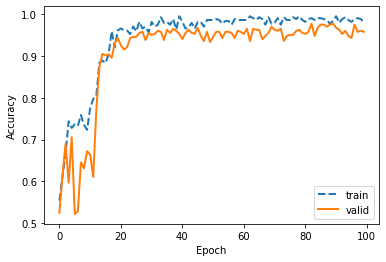

<Figure size 432x288 with 0 Axes>

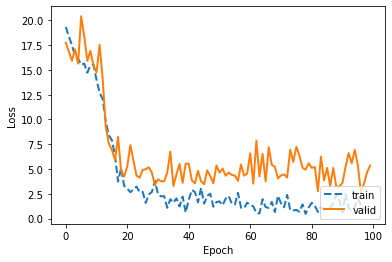

<Figure size 432x288 with 0 Axes>

In [14]:
tAccurs=[]
tLosses=[]
vAccurs=[]
vLosses=[]
gnn_model = GnnNew().to(device)
gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
gnn_best_model = 'RP_best_model.model'
gnn_last_model = 'RP_last_model.model'


for num_epoch in range(epochs):
        
    train_loss=0
    y_pred=[]
    y_true=[]
    
    t_start = time.time()
    gnn_model.train()        
    
    edges, non_edges = sample_equal_number_edges_non_edges(adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)
    
    samples = torch.cat((torch.Tensor(edges), torch.Tensor(non_edges)),dim=0).type(torch.long).to(device)
    target = torch.cat((torch.ones(len(edges)), torch.zeros(len(non_edges))),dim=0).type(torch.long).to(device)
       
    if minibatch_size > 0:
        train_batcher = MiniBatcher(minibatch_size, len(samples))
    else:
        train_batcher = MiniBatcher(len(samples), len(samples))

    for idxs in train_batcher.get_one_batch():
        idxs = idxs.to(device)        
        train_edges=samples[idxs]
        train_target=target[idxs]        
        nodex=torch.flatten(train_edges)  
        train_nodes=torch.unique(nodex.view(-1))
        
        #NewSubgraphMaker(Graph, edges, nodes)
        
        
        #subgraphs=NewSubgraphMaker(G_train, train_edges, nodex) 
        Graph=G_train        
        neighbor=NeighborSamplerNew(Graph)             
        graphGenerator=neighbor(nodex.cpu())    
        subgraphs=[]
        for graph in graphGenerator:  
            #print("subgraphNnode ",graph.num_nodes)
           # print("subgraphNid ",graph.n_id)
            #print("subgraphBid ",graph.b_id)
            sub_feature=torch.Tensor(Graph.x[graph.n_id])      
            x_feature=[]        
            for i in range(2):
                unique_feature=torch.zeros(len(sub_feature),1)
                for i_d in range(len(graph.n_id)):
                        if graph.b_id[i]==graph.n_id[i_d]:
                            pointu=i_d
                            break;           
                unique_feature[pointu]=1                        
                x_feature.append(torch.cat((sub_feature,unique_feature),dim=1).to(device))
            graph.x_feature=x_feature
            subgraphs.append(graph.to(device))   
        
        gnn_optimizer.zero_grad()                
        loss, pred=gnn_model.predict(subgraphs, train_nodes, train_edges, train_target)
        
        loss.backward()
        gnn_optimizer.step()
        
        train_loss+=loss.item()
            
        pred = F.log_softmax(pred, dim=1)
        pred = pred.detach().to("cpu").numpy()
        pred = np.argmax(pred, axis=1)

        y_pred = np.append(y_pred,pred)
        y_true = np.append(y_true,train_target.detach().to("cpu").numpy())
        
    
    t_end= time.time()
    print("Minibatch time: ",t_end-t_start)
    
    train_acc=accuracy_score(y_true, y_pred)
    tAccurs.append(train_acc)
    tLosses.append(train_loss)
    #predict_model(select, G_data, minibatch_size, small_samples):
    v_loss,v_acc,_,_=predict_model("val")
    vLosses.append(v_loss)
    vAccurs.append(v_acc)
    
    if v_acc > validation_acc:
            validation_acc = v_acc
            torch.save(gnn_model.state_dict(), gnn_best_model)
    
    print("-"*100)
    print("[Epoch {0}] Train Loss: {1}, Train Accuracy: {2}, Val Loss {3}, Val Accuracy: {4}".format(num_epoch, train_loss, train_acc, v_loss, v_acc))
    
torch.save(gnn_model.state_dict(), gnn_last_model)

save_plot(tAccurs, vAccurs, name='Accuracy')
save_plot(tLosses, vLosses, name='Loss')        

## Forward pass on the test graphs (best model)

In [20]:
#gnn_best_model = 'RP_best_model.model'
#gnn_model = GnnNew().to(device)
gnn_model.load_state_dict(torch.load('RP_best_model.model'))

from statistics import mean, stdev
run_count=12

test_accs=[]
test_micros=[]
test_weighteds=[]

for i in range(run_count):
    #predict_model(select, G_data, minibatch_size, small_samples):
    _,test_acc,test_micro,test_weighted=predict_model("test")
    test_accs.append(test_acc)
    test_micros.append(test_micro)
    test_weighteds.append(test_weighted)
    
print("{0} ({1})".format(mean(test_micros), stdev(test_micros)))

print("Test Micro F1 Score: ", mean(test_micros))
print("Test Weighted F1 Score: ", mean(test_weighteds))
print("Test Accuracy Score: ", mean(test_accs))

0.9412916099515466 (0.0029986183164883874)
Test Micro F1 Score:  0.9412916099515466
Test Weighted F1 Score:  0.9412889994019298
Test Accuracy Score:  0.9412916099515466


## Forward pass on the test graphs (last model)

In [21]:
#gnn_last_model = 'RP_last_model.model'
gnn_model = GnnNew().to(device)
gnn_model.load_state_dict(torch.load('RP_last_model.model'))

from statistics import mean, stdev
run_count=12

test_accs=[]
test_micros=[]
test_weighteds=[]

for i in range(run_count):
    _,test_acc,test_micro,test_weighted=predict_model("test")
    test_accs.append(test_acc)
    test_micros.append(test_micro)
    test_weighteds.append(test_weighted)
    
print("{0} ({1})".format(mean(test_micros), stdev(test_micros)))
    
print("Test Micro F1 Score: ", mean(test_micros))
print("Test Weighted F1 Score: ", mean(test_weighteds))
print("Test Accuracy Score: ", mean(test_accs))

0.9428090658387438 (0.002807733515002018)
Test Micro F1 Score:  0.9428090658387438
Test Weighted F1 Score:  0.9428075284818581
Test Accuracy Score:  0.9428090658387438


## Scratch

In [17]:
train_batcher = MiniBatcher(2, 10) if minibatch_size > 0 else MiniBatcher(10, 10)

for i in range(3):
    for train_idxs in train_batcher.get_one_batch():
        print(train_idxs)
    print("")


tensor([8, 4])
tensor([2, 0])
tensor([5, 7])
tensor([3, 6])
tensor([9, 1])

tensor([5, 9])
tensor([6, 3])
tensor([0, 4])
tensor([8, 7])
tensor([2, 1])

tensor([9, 7])
tensor([0, 1])
tensor([2, 5])
tensor([6, 3])
tensor([4, 8])



In [18]:
a=torch.Tensor([[1,2],[3,1],[4,5]])
b=torch.unique(torch.flatten(a).view(-1))

k=1
A = kneighbors_graph(a, k, mode="connectivity", metric="cosine", include_self=False)        
(u,v)=A.nonzero()
print(u,v)

a[a==1]=3

print(a)

[0 1 2] [2 2 0]
tensor([[3., 2.],
        [3., 3.],
        [4., 5.]])


In [19]:
for i in range(10):
    print(np.random.randint(2))
    
    print(test)

0


NameError: name 'test' is not defined